In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import head_direction as hd
import place_stimulation as ps
import expipe
import os
import pathlib
import math
import numpy as np
import exdir
from exdir.plugins import quantities
from scipy.interpolate import interp1d
import pandas as pd

In [17]:
speed_filter = 5 # m/s
pos_fs = 100 
f_cut = 6
box_xlen = 1 
box_ylen = 1 
binsize =  0.02
smoothing = 0.03


plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize') or
        k.endswith('titlesize')
    )
})

In [18]:
#project_path = "C:\\Projects\eight-maze-theta"
project_path = "../"
project = expipe.get_project(project_path)
actions = project.actions

C:\apps\Anaconda3\envs\expipe1\lib\site-packages\expipe\core.py:699: UserWarning: Requested project with name '..', but found 'eight-maze-theta'
  "'{}', but found '{}'".format(name, project))


In [19]:
def make_rate_map(x, y, t, sptr, a, at, binsize, smoothing, mask_zero_occupancy=False):
    from matplotlib import gridspec

    fig = plt.figure()
    gs = gridspec.GridSpec(1,4)
    axs = [fig.add_subplot(g, projection=p) for g, p in zip(gs, [None, None, None, 'polar'])]
    spatial_map = sp.SpatialMap(
        x, y, t, sptr, box_size=1.0, bin_size=binsize)
    
    rate_map = spatial_map.rate_map(smoothing=smoothing, mask_zero_occupancy=mask_zero_occupancy)
    
    axs[0].imshow(rate_map, vmin=0)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_title('channel group {} {}'.format(
        sptr.annotations['group_id'], sptr.annotations['name']))
    axs[1].plot(x, y, 'k', alpha=0.3)
    # Remove spikes that fall outside the range of times.
    # Otherwise, interpolation will fail when plotting spikes in scatter plot.
    sptr = sptr[(sptr > min(t)) & (sptr < max(t))]
    
    x_spike = interp1d(t,x)(sptr)
    y_spike = interp1d(t,y)(sptr)
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    
    axs[1].scatter(x_spike, y_spike, marker='.', color=(0.7, 0.2, 0.2), s=2)
    axs[1].set_ylim(1,0)
    axs[1].set_title('N spikes {}'.format(len(spike_times)))
    
    occupancy_map = spatial_map.occupancy_map(smoothing=smoothing, mask_zero_occupancy=mask_zero_occupancy)
    
    axs[2].imshow(occupancy_map, vmin=0)
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    axs[2].set_title('occupancy')

    
    ang_bins, rate_ang = hd.head_direction_rate(sptr, a, at)
    hd_dir, hd_score = hd.head_direction_score(ang_bins, rate_ang)
    hd_dir = math.degrees(hd_dir)
    binsize = ang_bins[1] - ang_bins[0]
    axs[3].set_xticks([0, np.pi])
    axs[3].bar(ang_bins, rate_ang, width=binsize, color='b')
    axs[3].set_title('hd {:.2f}, {:.1f} deg'.format(hd_score, hd_dir))
    
    for ax in axs:
        ax.set_aspect(1)

In [20]:
actions

In [23]:
action_id = "MBR-0013-250820-1"
channel_ids = range(8)
t_start = 0
t_stop = None

action  = actions[action_id]

data_path = ps.get_data_path(action)
root_group = exdir.File(
    data_path, plugins=[exdir.plugins.quantities])

Project path: C:\Projects\eight-maze-theta\notebooks\..
Data path: actions\MBR-0013-250820-1\data\main.exdir


Removed 0.00 % invalid measurements in path
28.287470180696104 Hz
Removed 0.0 % of tracking samples
Maximum speed 0.9060978995126197
Maximum speed 1.1028804362077629
No spikes in channel group 0
No spikes in channel group 1
No spikes in channel group 2


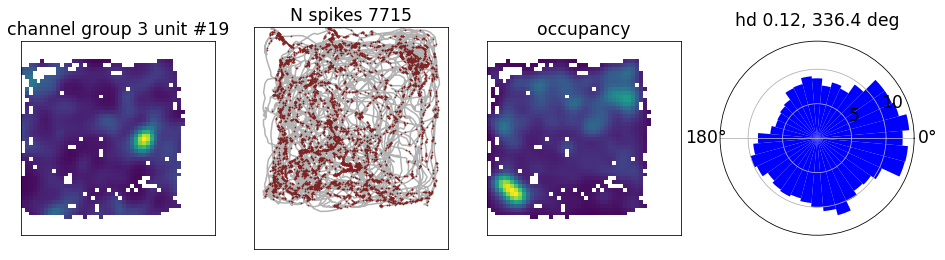

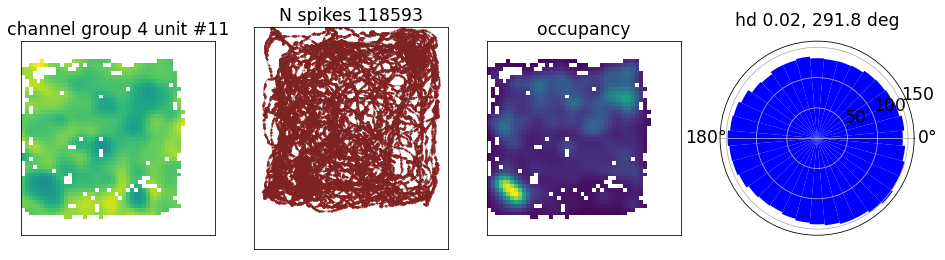

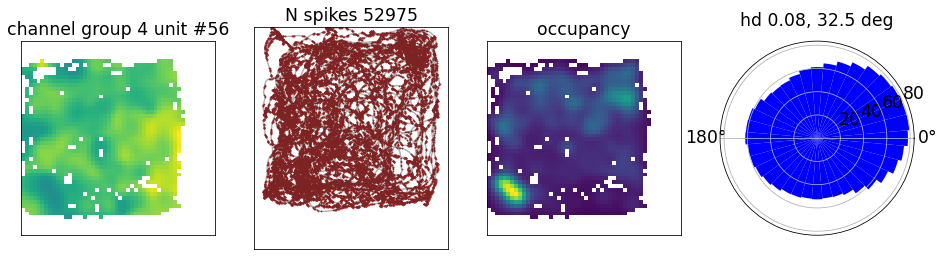

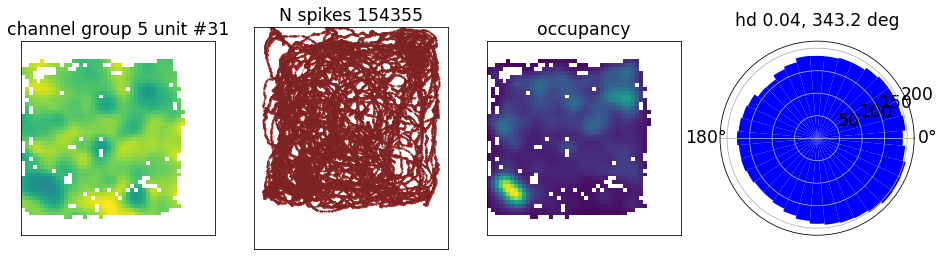

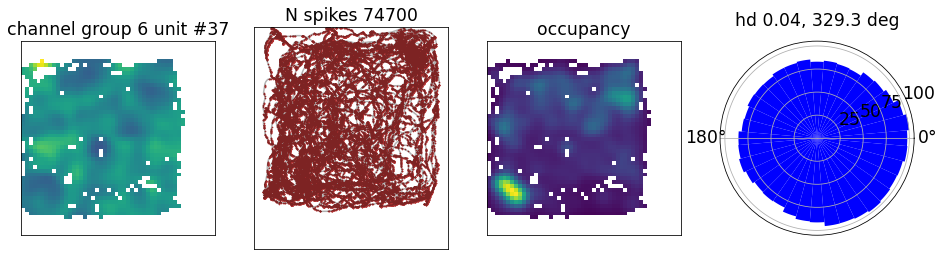

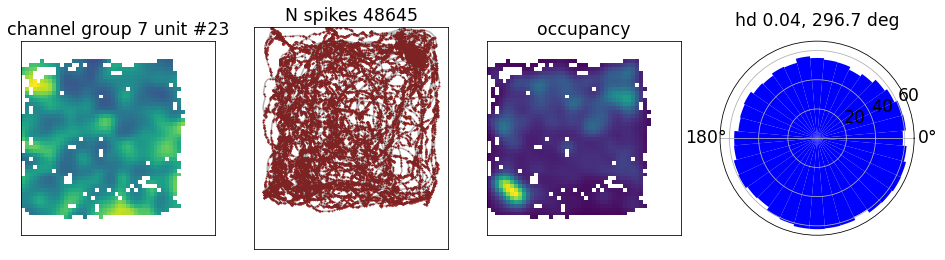

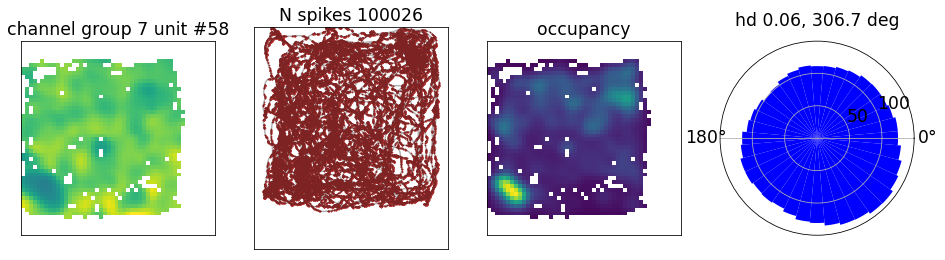

In [24]:
x, y, t, speed = ps.load_tracking(data_path)
a, at = ps.tools.load_head_direction(data_path, 100, 5, [1,1])

if t_start is not None and t_stop is not None:
    mask = (t < t_stop) & (t > t_start)
    x, y, t = x[mask], y[mask], t[mask]

for channel_id in channel_ids:
    spike_trains = ps.load_spiketrains(data_path, channel_id, load_waveforms=True)
    if len(spike_trains) == 0:
        print('No spikes in channel group {}'.format(channel_id))
        continue
            
#     spike_trains = dp.sort_by_cluster_id(spike_trains)
    for spike_times in spike_trains:
        if t_start is not None and t_stop is not None:
            spike_mask = (spike_times < t_stop) & (spike_times > t_start)
            spike_times = spike_times[spike_mask]

        make_rate_map(
            x, y, t, spike_times, 
            a, at, 
            binsize, smoothing, mask_zero_occupancy=True)
    